# First read the VNA frequency scan CSV files

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
def read_targeted_csv_files(directory, target_frequency):
    plot_data_target_frequency = {}
    for filename in os.listdir(directory):
        if filename.endswith('.csv') and ('FS' in filename or 'VNA' in filename) and '11' in filename:
            date = filename[:6]
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            row = df[df.iloc[:, 0] == target_frequency]
            if not row.empty:
                wp = 'wp1' if 'wp1' in filename else 'wp0'
                linestyle = '--' if wp == 'wp1' else '-'
                color_start = filename.find(wp) + 3
                color_end = filename.find('FS') if 'FS' in filename else filename.find('VNA')
                color = filename[color_start:color_end]
                color = 'pink' if color == 'p' else 'grey' if color == 'w' else color
                if wp not in plot_data_target_frequency:
                    plot_data_target_frequency[wp] = {}
                if color not in plot_data_target_frequency[wp]:
                    plot_data_target_frequency[wp][color] = {}
                if date not in plot_data_target_frequency[wp][color]:
                    plot_data_target_frequency[wp][color][date] = {}
                for column in df.columns[1:]:
                    if column not in plot_data_target_frequency[wp][color][date]:
                        plot_data_target_frequency[wp][color][date][column] = row[column].values[0]
    return plot_data_target_frequency




# Prepare the env data CSV file for date matching 

In [ ]:

def read_processed_output(processed_output_file, x_axis_variable):
    processed_df = pd.read_csv(processed_output_file)
    env_data = {}
    for index, row in processed_df.iterrows():
        date = row['Date']
        env_info = row[x_axis_variable]
        env_data[date] = env_info
    return env_data


# Prepare the 2D plotting functions
## Takes the columns from the prepared env csv file and uses them as the x axis in replacement to the dates from the FS variables

## This function plots the FS variable on the y, the env variable on the x as a scatter plot with the points as dates

In [ ]:

def plot_2d_data_dates(plot_data_target_frequency, env_data, plot_outdir, target_frequency, x_axis_variable, variable_keywords=None, colors=None):
    if not os.path.exists(plot_outdir):
        os.makedirs(plot_outdir)
    for wp, colors_dict in plot_data_target_frequency.items():
        for color, dates in colors_dict.items():
            if colors and color not in colors:
                continue
            for column in next(iter(dates.values())).keys():
                if variable_keywords and not any(keyword.lower() in column.lower() for keyword in variable_keywords):
                    continue
                plt.figure()
                sorted_dates = sorted(dates.keys())
                for date in sorted_dates:
                    columns = dates[date]
                    formatted_date = f"20{date[4:6]}-{date[:2]}-{date[2:4]}"
                    if column in columns and formatted_date in env_data:
                        plt.plot(env_data[formatted_date], columns[column], 'o', linestyle='--' if wp == 'wp1' else '-', label=date)
                plt.xlabel(x_axis_variable)
                plt.ylabel(column)
                plt.title(f'{column} at {target_frequency} Hz - {wp} - {color.replace("grey", "white")}')
                plt.legend()
                plt.savefig(os.path.join(plot_outdir, f'{column}_{x_axis_variable}_{target_frequency}Hz_{wp}_{color}.png'))
                plt.close()





## This function plots the Magnitude vs. Frequency for every day in the csv sets
Can turn on and off the flag for humidity or temp instead of dates
Zoom = True looks at plot where you are looking only > 2 MHz

In [ ]:

def plot_stack_plot(directory, plot_outdir, colors, target_frequency, convert_dates_to_humidity=False, zoom=False, processed_output_file=None):
    if not os.path.exists(plot_outdir):
        os.makedirs(plot_outdir)
    
    plot_data = {'wp0': {'pink': {}, 'grey': {}}, 'wp1': {'pink': {}, 'grey': {}}}
    
    for filename in os.listdir(directory):
        if filename.endswith('.csv') and ('FS' in filename or 'VNA' in filename):
            date = filename[:6]
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            wp = 'wp1' if 'wp1' in filename else 'wp0'
            color_start = filename.find(wp) + 3
            color_end = filename.find('FS') if 'FS' in filename else filename.find('VNA')
            color = filename[color_start:color_end]
            color = 'pink' if color == 'p' else 'grey' if color == 'w' else color
            
            if color not in colors:
                continue
            
            for column in df.columns[1:]:
                if 'magnitude' in column.lower():
                    if column not in plot_data[wp][color]:
                        plot_data[wp][color][column] = {}
                    plot_data[wp][color][column][date] = df[[df.columns[0], column]]
    
    if convert_dates_to_humidity and processed_output_file:
        env_data = read_processed_output(processed_output_file, 'Humidity')
        conditional = "humidity"
    else: 
        conditional = "date"
    if zoom: 
        conditional += "_zoom"
    
    for wp in plot_data:
        for color in plot_data[wp]:
            plt.figure()
            plotted_dates = set()
            unique_colors = plt.get_cmap('tab20', len(plot_data[wp][color])).colors  # Generate unique colors
            color_index = 0
            for column in plot_data[wp][color]:
                sorted_dates = sorted(plot_data[wp][color][column].keys())
                for date in sorted_dates:
                    data = plot_data[wp][color][column][date]
                    data.iloc[:, 0] = data.iloc[:, 0] / 1_000_000  # Convert frequency to MHz
                    if zoom:
                        data = data[data.iloc[:, 0] <= 1.5]
                    if date not in plotted_dates:
                        if convert_dates_to_humidity and processed_output_file:
                            formatted_date = f"20{date[4:6]}-{date[:2]}-{date[2:4]}"
                            if formatted_date in env_data:
                                plt.plot(data.iloc[:, 0], data.iloc[:, 1], label=f'Rel. Humidity: {env_data[formatted_date]}', color=unique_colors[color_index % len(unique_colors)])
                        else:
                            plt.plot(data.iloc[:, 0], data.iloc[:, 1], label=f'{date}', color=unique_colors[color_index % len(unique_colors)])
                        plotted_dates.add(date)
                        color_index += 1
            
            plt.xlabel('Frequency (MHz)')
            plt.ylabel('Magnitude (dB)')
            plt.title(f'Stack Plot - {wp} - {color.replace("grey", "white")}')
            plt.legend(fontsize='small')
            plt.savefig(os.path.join(plot_outdir, f'stack_plot_{conditional}_{wp}_{color.replace("grey", "white")}.png'))
            plt.show()
            plt.close()


## Plot the scope traces

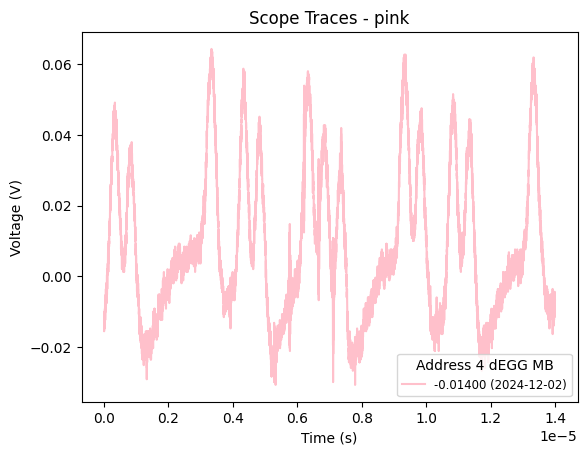

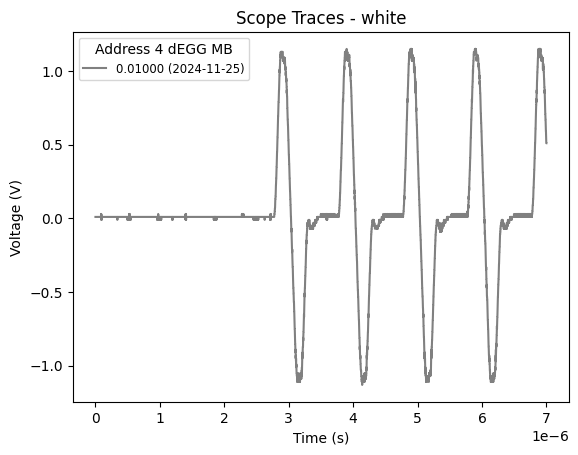

In [ ]:
# Define the file paths
scope_files = {
    'pink': '/home/victoria/work/icecube/service/nts/NTS_VNA/csv/120224wp0pSCOPEcloser.csv',
    'white': '/home/victoria/work/icecube/service/nts/NTS_VNA/csv/112524wp0wSCOPEyesridge.csv'
}

# Read and plot the scope files
for color, filepath in scope_files.items():
    df = pd.read_csv(filepath, skiprows=13)  # Skip the metadata rows
    date = filepath.split('/')[-1][:6]  # Extract the date from the filename
    formatted_date = f"20{date[4:6]}-{date[:2]}-{date[2:4]}"  # Format the date as YYYY-MM-DD
    plt.figure()
    for column in df.columns[1:]:
        plt.plot(df.iloc[:, 0], df[column], label=f'{column} ({formatted_date})', color=color.replace("white", "grey"))
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.title(f'Scope Traces - {color}')
    plt.legend(title='Address 4 dEGG MB', fontsize='small', title_fontsize='medium')
    plt.show()

# Prepare the 3D plotting function
Takes the columns from the prepared csv file for the DATE and plots other env variables as the z axis against FS variables

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np

def plot_2d_heatmap(plot_data_target_frequency, env_data, plot_outdir, target_frequency, x_axis_variable, variable_keywords=None, colors=None):
    if not os.path.exists(plot_outdir):
        os.makedirs(plot_outdir)
    for wp, colors_dict in plot_data_target_frequency.items():
        for color, dates in colors_dict.items():
            if colors and color not in colors:
                continue
            for column in next(iter(dates.values())).keys():
                if variable_keywords and not any(keyword.lower() in column.lower() for keyword in variable_keywords):
                    continue
                sorted_dates = sorted(dates.keys())
                x_data = []
                y_data = []
                z_data = []
                for date in sorted_dates:
                    columns = dates[date]
                    formatted_date = f"20{date[4:6]}-{date[:2]}-{date[2:4]}"
                    if column in columns and formatted_date in env_data:
                        x_data.append(formatted_date)
                        y_data.append(columns[column])
                        z_data.append(env_data[formatted_date])
                
                # Convert dates to numerical format for plotting
                x_data = np.arange(len(x_data))
                y_data = np.array(y_data)
                z_data = np.array(z_data)
                
                # Create meshgrid for plotting
                x_mesh, y_mesh = np.meshgrid(x_data, y_data)
                z_mesh = np.zeros_like(x_mesh)
                
                for i, x in enumerate(x_data):
                    for j, y in enumerate(y_data):
                        mask = (x_data == x) & (y_data == y)
                        if np.any(mask):
                            z_mesh[j, i] = z_data[mask][0]
                
                fig, ax = plt.subplots()
                c = ax.pcolormesh(x_mesh, y_mesh, z_mesh, shading='auto', cmap='viridis')
                fig.colorbar(c, ax=ax, label=x_axis_variable)
                ax.set_xlabel('Date')
                ax.set_ylabel(column)
                ax.set_title(f'{column} at {target_frequency} Hz - {wp} - {color.replace("grey", "white")}')
                
                # Save the plot
                plot_filename = f'{column}_{x_axis_variable}_{target_frequency}Hz_{wp}_{color.replace("grey", "white")}_heatmap.png'
                plt.savefig(os.path.join(plot_outdir, plot_filename))
                plt.close()

# Run the plotting scripts 
By grabbing the updated env csv and FS files

In [ ]:
def plot_2d_data_dates_with_dates(directory, plot_outdir, target_frequency, x_axis_variable, processed_output_file, variable_keywords=None, colors=None):
    plot_data_target_frequency_dict = read_targeted_csv_files(directory, target_frequency)
    env_data_dict = read_processed_output(processed_output_file, x_axis_variable)
    plot_2d_data_dates(plot_data_target_frequency_dict, env_data_dict, plot_outdir, target_frequency, x_axis_variable, variable_keywords, colors)

def plot_2d_heatmap_with_dates(directory, plot_outdir, target_frequency, x_axis_variable, processed_output_file, variable_keywords=None, colors=None):
    plot_data_target_frequency_dict = read_targeted_csv_files(directory, target_frequency)
    env_data_dict = read_processed_output(processed_output_file, x_axis_variable)
    plot_2d_heatmap(plot_data_target_frequency_dict, env_data_dict, plot_outdir, target_frequency, x_axis_variable, variable_keywords, colors)

# User usage below

/tmp/ipykernel_593466/1604909639.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.000
1      0.008
2      0.016
3      0.024
4      0.032
       ...  
496    3.968
497    3.976
498    3.984
499    3.992
500    4.000
Name: Frequency, Length: 501, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 0] = data.iloc[:, 0] / 1_000_000  # Convert frequency to MHz
/tmp/ipykernel_593466/1604909639.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.000
1      0.008
2      0.016
3      0.024
4      0.032
       ...  
496    3.968
497    3.976
498    3.984
499    3.992
500    4.000
Name: Frequency, Length: 501, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 0] = data.iloc[:, 0] / 1_000_000  # Conve

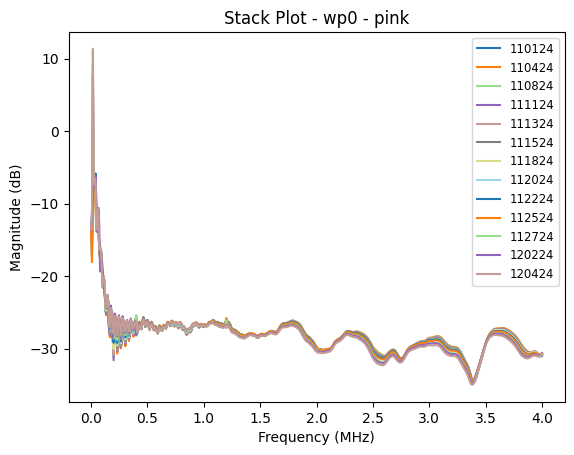

/tmp/ipykernel_593466/1604909639.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.000
1      0.008
2      0.016
3      0.024
4      0.032
       ...  
496    3.968
497    3.976
498    3.984
499    3.992
500    4.000
Name: Frequency, Length: 501, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 0] = data.iloc[:, 0] / 1_000_000  # Convert frequency to MHz
/tmp/ipykernel_593466/1604909639.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.000
1      0.008
2      0.016
3      0.024
4      0.032
       ...  
496    3.968
497    3.976
498    3.984
499    3.992
500    4.000
Name: Frequency, Length: 501, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 0] = data.iloc[:, 0] / 1_000_000  # Conve

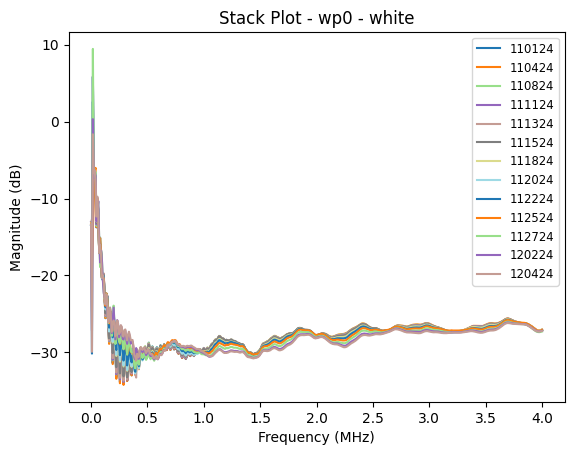

/tmp/ipykernel_593466/1604909639.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.000
1      0.008
2      0.016
3      0.024
4      0.032
       ...  
496    3.968
497    3.976
498    3.984
499    3.992
500    4.000
Name: Frequency, Length: 501, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 0] = data.iloc[:, 0] / 1_000_000  # Convert frequency to MHz
/tmp/ipykernel_593466/1604909639.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.000
1      0.008
2      0.016
3      0.024
4      0.032
       ...  
496    3.968
497    3.976
498    3.984
499    3.992
500    4.000
Name: Frequency, Length: 501, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 0] = data.iloc[:, 0] / 1_000_000  # Conve

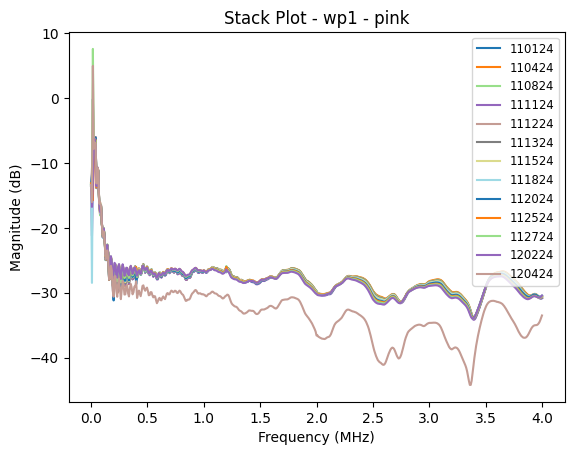

/tmp/ipykernel_593466/1604909639.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.000
1      0.008
2      0.016
3      0.024
4      0.032
       ...  
496    3.968
497    3.976
498    3.984
499    3.992
500    4.000
Name: Frequency, Length: 501, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 0] = data.iloc[:, 0] / 1_000_000  # Convert frequency to MHz
/tmp/ipykernel_593466/1604909639.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.000
1      0.008
2      0.016
3      0.024
4      0.032
       ...  
496    3.968
497    3.976
498    3.984
499    3.992
500    4.000
Name: Frequency, Length: 501, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 0] = data.iloc[:, 0] / 1_000_000  # Conve

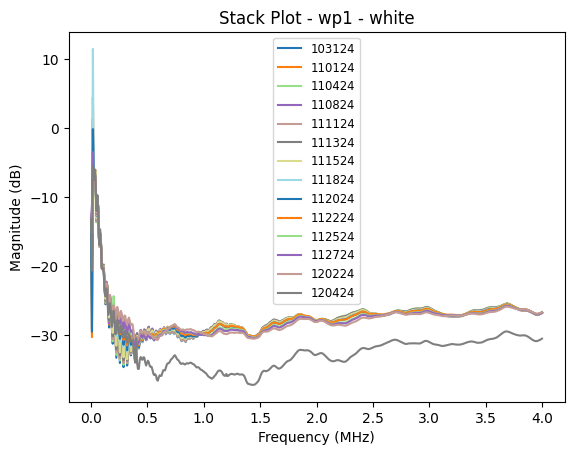

In [ ]:
from datetime import datetime

directory = '/home/victoria/work/icecube/service/nts/NTS_VNA/csv'
# processed_output_file = '/home/victoria/work/icecube/service/nts/NTS_VNA/csv/processed_output.csv'
processed_output_file = '/home/victoria/work/icecube/service/nts/NTS_VNA/csv/new_processed_output.csv'
today_date = datetime.today().strftime('%Y%m%d')
plot_outdir = f'/home/victoria/work/icecube/service/nts/NTS_VNA/plots_{today_date}'

target_frequency = 2000000
variable_keywords = ['magnitude', 'impedance']
x_axis_variable = 'Humidity'
# x_axis_variable = 'Wire Temp [C]'
# x_axis_variable = 'Air Temp [C]'
# x_axis_variable = 'Date'
colors_to_plot = ['pink', 'grey']

# plot_2d_data_dates_with_dates(directory, plot_outdir, target_frequency, x_axis_variable, processed_output_file, variable_keywords=variable_keywords, colors=colors_to_plot)
# plot_2d_heatmap_with_dates(directory, plot_outdir, target_frequency, x_axis_variable, processed_output_file, variable_keywords=variable_keywords, colors=colors_to_plot)
plot_stack_plot(directory, plot_outdir, colors_to_plot, target_frequency, convert_dates_to_humidity=False, zoom=False, processed_output_file=processed_output_file)

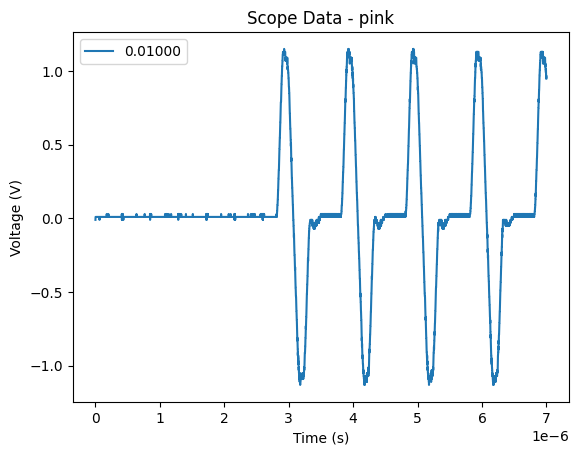

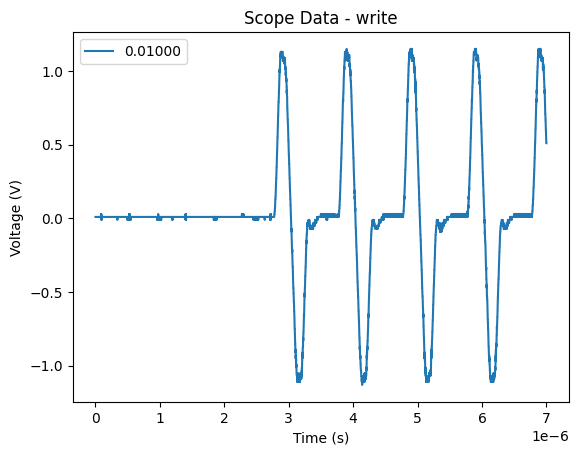